In [1]:
import torch
import os
import pathlib
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF

In [ ]:
# Model Importing Pls change to the path where the model is present.
# additional util functions are also imported.

from model_torch import *

In [2]:
# Training


faces_X_train = pathlib.Path('./dataset/train/faces/')
faces_y_train = pathlib.Path('./dataset/train/train_faces.csv')
landmarks_X_train = pathlib.Path('./dataset/train/landmarks')
landmarks_y_train = pathlib.Path('./dataset/train/train_landmarks.csv')

#Testing

faces_X_test = pathlib.Path('./dataset/test/faces')
landmarks_X_test = pathlib.Path('./dataset/test/landmarks')


faces_X_train, faces_y_train, landmarks_X_train, landmarks_y_train, faces_X_test, landmarks_X_test

(WindowsPath('dataset/train/faces'),
 WindowsPath('dataset/train/train_faces.csv'),
 WindowsPath('dataset/train/landmarks'),
 WindowsPath('dataset/train/train_landmarks.csv'),
 WindowsPath('dataset/test/faces'),
 WindowsPath('dataset/test/landmarks'))

In [3]:
def PreProcessLabelDF(df):
    df.index = df.image
    df = df.drop(columns = ['image'])
    cols = dict(zip([int(i) for i in df.columns], range(1, 37)))
    x = dict(zip(df.columns, [cols for i in range(36)]))
    df.replace(x, inplace=True)
    return df

def visualize_ds(ds):
    fig = plt.figure(figsize = (12, 24))
    j = 1
    for i in range(4):
        sample = ds[i]

        ax = plt.subplot(4, 2, j)
        ax.axis('off')
        j += 1
        plt.imshow(sample[0].permute(1, 2, 0))
        ax = plt.subplot(4, 2, j)
        ax.axis('off')
        j += 1
        plt.imshow(sample[1])

        if i == 3:
            plt.show()
            break


def get_label(df, name):
    label = np.zeros((36, 36))
    for index, pos in enumerate(df.loc[name]):
        label[index][pos-1] = 1
    return label

In [4]:
class DS(Dataset):
    def __init__(self, image_paths, label_ds, transform = None):
        self.image_paths = image_paths
        self.label_ds = label_ds
        self.transform = transform
        
    def preprocess_label_df(self):
        self.label_ds.index = self.label_ds.image
        self.label_ds = self.label_ds.drop(columns = ['image'])
        cols = dict(zip([int(i) for i in self.label_ds.columns], range(1, 37)))
        x = dict(zip(self.label_ds.columns, [cols for i in range(36)]))
        self.label_ds.replace(x, inplace=True)

    def __getitem__(self, idx):
        x = Image.open(self.image_paths[idx])
        y = torch.zeros(36, 36)
        
        for index, pos in enumerate(self.label_ds.loc[self.image_paths[idx].split(os.path.sep)[-1]]):
            y[index][pos-1] = 1  
            
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
faces_image_paths = list(map(str, faces_X_train.glob('*.jpg')))
landmarks_image_paths = list(map(str, landmarks_X_train.glob('*.jpg')))

faces_dataset = DS(image_paths = faces_image_paths,
                   label_ds = PreProcessLabelDF(pd.read_csv(faces_y_train)),
                   transform = transforms.Compose([
                                               ToTensor()
                                           ])
                  )  
landmarks_dataset = DS(image_paths = landmarks_image_paths,
                       label_ds = PreProcessLabelDF(pd.read_csv(landmarks_y_train)),
                       transform = transforms.Compose([
                                               ToTensor()
                                           ])
                      )
            
# visualize_ds(faces_dataset)
# visualize_ds(landmarks_dataset)

In [31]:
# Dataset
faces_train, faces_val, faces_test = torch.utils.data.random_split(faces_dataset, [0.7, .1, .2])
landmarks_train, landmarks_val, landmarks_test = torch.utils.data.random_split(landmarks_dataset, [0.7, .1, .2])


faces_train, faces_val, faces_test = DataLoader(faces_train, shuffle = True, batch_size = 5), DataLoader(faces_val, shuffle = True, batch_size = 5), DataLoader(faces_test, shuffle = True, batch_size = 5)
landmarks_train, landmarks_val, landmarks_test = DataLoader(landmarks_train, shuffle = True, batch_size = 5), DataLoader(landmarks_val, shuffle = True, batch_size = 5), DataLoader(landmarks_test, shuffle = True, batch_size = 5)


full_ds = torch.utils.data.ConcatDataset([faces_dataset, landmarks_dataset])

train_ds, val_ds, test_ds = torch.utils.data.random_split(full_ds, [0.7, .1, .2])
train_ds, val_ds, test_ds = DataLoader(train_ds, shuffle = True, batch_size = 5), DataLoader(val_ds, shuffle = True, batch_size = 5), DataLoader(test_ds, shuffle = True, batch_size = 5)


full_dl = DataLoader(full_ds, shuffle = True, batch_size = 5)

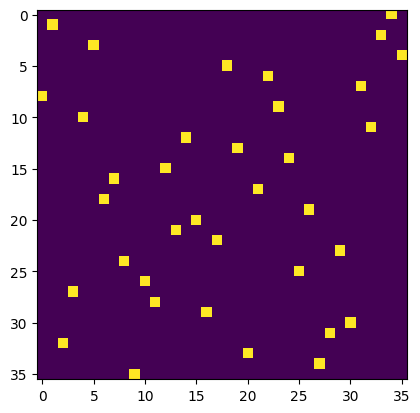

In [18]:
# showcase a random Sample of the label 

df = PreProcessLabelDF(pd.read_csv(faces_y_train))
plt.imshow(get_label(df, df.sample().index[0]))

In [ ]:
# Todo: Metrics and Loss function to be configured to specific use case.

def validate_model(model, dataset):
    with torch.inference_mode():
        for data in dataset:
            inputs, labels = data
            preds = model(inputs)
            print(f' Tau Statistic : {kendalltau(preds, labels).statistic} Hamming Similarity: {hamming_loss(preds, labels)}')
            
def evaluate_model(model, dataset):
    with torch.inference_mode():
        for data in dataset:
            inputs, labels = data
            preds = model(inputs)
            print(f' Tau Statistic : {kendalltau(preds, labels).statistic} Hamming Similarity: {hamming_loss(preds, labels)}')

In [ ]:
# Define the model, Optimizer and Loss Function.

# Todo: To be improved and Loss function has to be tailored to specific use case.

# Metrics also to be configured to specific use case.

# refer: https://arxiv.org/pdf/1704.02729.pdf


model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()



def train_epoch(epoch_index):
    for i, data in enumerate(faces_train_ds):
        inputs, labels = data
        print(torch.isnan(inputs).any(), torch.isnan(inputs).any())

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        print(f'Batch {i+1} Loss: {loss.item()}')

    return loss.item()   

In [ ]:
EPOCHS = 5
# Batch Size is already fixed to 5 in dataset creation.


for epoch in range(EPOCHS):
    epoch_loss = train_epoch(epoch)
    print(f'Epoch {epoch + 1} Loss : {epoch_loss}')
    if epoch % 2 == 1:
        print(f'Validation at {epoch + 1}')
        validate_model(model, faces_val)
    if epoch % 3 == 2:
        print(f'Testing at {epoch + 1}')
        evaluate_model(model, faces_test)